<a href="https://colab.research.google.com/github/MKolaksazov/Machine-Learning/blob/master/Kaggle%20competitions/Forest_Cover_Type_Kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forest Cover Type Prediction
####**Use cartographic variables to classify forest categories**

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. In this competition you are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data).

Installing and downloading Kaggle; 
</br>Copying Json file Kaggle.json;
</br>downloading the competition database;

In [1]:
! pip install kaggle
! mkdir ~/.kaggle

In [3]:
from google.colab import files
# uploading the kaggle.json file
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"markokolaksazov","key":"7bc9a5f2e932ee7bda5caa7dc3073486"}'}

In [4]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download forest-cover-type-prediction

  0% 0.00/1.19M [00:00<?, ?B/s]
100% 1.19M/1.19M [00:00<00:00, 51.6MB/s]
  0% 0.00/333k [00:00<?, ?B/s]
100% 333k/333k [00:00<00:00, 108MB/s]
 84% 10.0M/11.9M [00:00<00:00, 101MB/s]
100% 11.9M/11.9M [00:00<00:00, 110MB/s]
sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/161 [00:00<?, ?B/s]
100% 161/161 [00:00<00:00, 134kB/s]


In [8]:
! mkdir unzip
! unzip train.csv.zip -d unzip
! unzip test.csv.zip -d unzip

mkdir: cannot create directory ‘unzip’: File exists
Archive:  train.csv.zip
  inflating: unzip/train.csv         
Archive:  test.csv.zip
  inflating: unzip/test.csv          


In [9]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns

#import os

# THE ML MODEL

# Redaing data from csv files

Unzipping the csv files and loading them

In [10]:
train = pd.read_csv("/content/unzip/train.csv")
train = train.drop(['Id'], axis=1)
y = train.iloc[:,-1]
train = train.iloc[:,:-1]
test = pd.read_csv("/content/unzip/test.csv")
test_Id = test.iloc[:,0]
test = test.drop(['Id'], axis=1)

In [11]:
all_data = train.append(test)
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [12]:
all_data.shape

(581012, 54)

In [13]:
train.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,23

In [14]:
# readings in these soil types are equal to zero and would not affect the prediction
train = train.drop(['Soil_Type7','Soil_Type15'], axis=1)

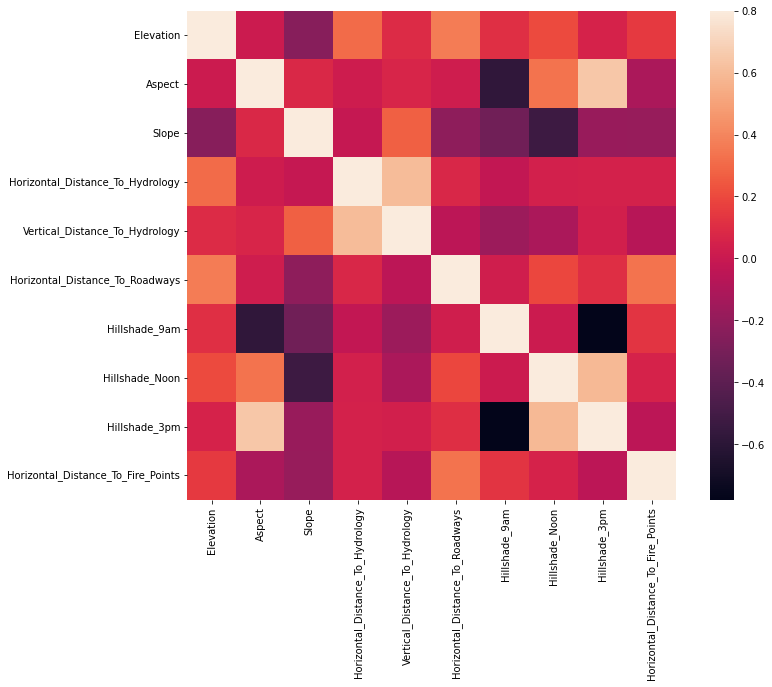

In [16]:
#correlation matrix
corrmat = all_data.iloc[:,:10].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

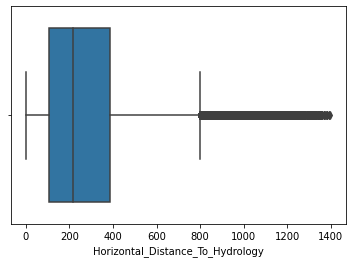

In [15]:
sns.boxplot('Horizontal_Distance_To_Hydrology', data = all_data)

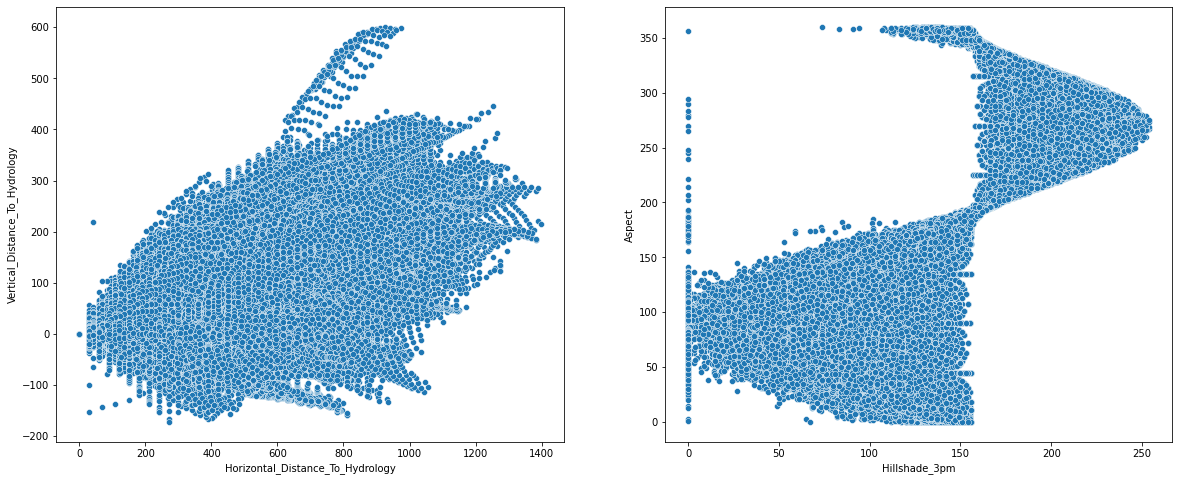

In [17]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.scatterplot(x = 'Horizontal_Distance_To_Hydrology', y = 'Vertical_Distance_To_Hydrology', data = all_data)
plt.subplot(1,2,2)
sns.scatterplot(x = 'Hillshade_3pm', y = 'Aspect', data = all_data)

In [18]:
a = all_data['Horizontal_Distance_To_Hydrology']
b = all_data['Vertical_Distance_To_Hydrology']
all_data['distance_to_hydrology'] = np.sqrt(np.power(a,2) + np.power(b,2))
all_data['Horizontal_distance'] = (all_data['Horizontal_Distance_To_Hydrology'] + all_data['Horizontal_Distance_To_Roadways']  + all_data['Horizontal_Distance_To_Fire_Points'])/3
all_data['average_hillshade'] = (all_data['Hillshade_3pm'] + all_data['Hillshade_Noon'] + all_data['Hillshade_9am'])/3
# high negative correlation, therefore making new feature
all_data['Aspect_hillshade'] = (all_data['Aspect']*all_data['Hillshade_9am'])/255
all_data['slope_hillshade'] = (all_data['Slope']*all_data['Hillshade_Noon'])/255
all_data['Elevation'] = [math.floor(v/50.0) for v in all_data['Elevation']]

In [19]:
all_data['EVDtH'] = all_data.Elevation-all_data.Vertical_Distance_To_Hydrology

all_data['EHDtH'] = all_data.Elevation-all_data.Horizontal_Distance_To_Hydrology*0.2

all_data['Distanse_to_Hydrolody'] = (all_data['Horizontal_Distance_To_Hydrology']**2+all_data['Vertical_Distance_To_Hydrology']**2)**0.5

all_data['Hydro_Fire_1'] = all_data['Horizontal_Distance_To_Hydrology']+all_data['Horizontal_Distance_To_Fire_Points']

all_data['Hydro_Fire_2'] = abs(all_data['Horizontal_Distance_To_Hydrology']-all_data['Horizontal_Distance_To_Fire_Points'])

all_data['Hydro_Road_1'] = abs(all_data['Horizontal_Distance_To_Hydrology']+all_data['Horizontal_Distance_To_Roadways'])

all_data['Hydro_Road_2'] = abs(all_data['Horizontal_Distance_To_Hydrology']-all_data['Horizontal_Distance_To_Roadways'])

all_data['Fire_Road_1'] = abs(all_data['Horizontal_Distance_To_Fire_Points']+all_data['Horizontal_Distance_To_Roadways'])

all_data['Fire_Road_2'] = abs(all_data['Horizontal_Distance_To_Fire_Points']-all_data['Horizontal_Distance_To_Roadways'])

In [20]:
all_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,distance_to_hydrology,Horizontal_distance,average_hillshade,Aspect_hillshade,slope_hillshade,EVDtH,EHDtH,Distanse_to_Hydrolody,Hydro_Fire_1,Hydro_Fire_2,Hydro_Road_1,Hydro_Road_2,Fire_Road_1,Fire_Road_2
0,51,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,258.000000,2349.000000,200.333333,44.200000,2.729412,51,-0.6,258.000000,6537,6021,768,252,6789,5769
1,51,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,212.084889,2275.666667,202.000000,48.313725,1.843137,57,8.6,212.084889,6437,6013,602,178,6615,5835
2,56,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,275.769832,3189.666667,202.333333,127.552941,8.400000,-9,2.4,275.769832,6389,5853,3448,2912,9301,2941
3,55,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,269.235956,3181.000000,199.333333,144.666667,16.800000,-63,6.6,269.235956,6453,5969,3332,2848,9301,3121
4,51,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,153.003268,2238.666667,201.333333,38.823529,1.835294,52,20.4,153.003268,6325,6019,544,238,6563,5781


In [21]:
all_data.shape

(581012, 68)

In [22]:
num_labels = [i for i in all_data.columns[0:10]]
b = ['distance_to_hydrology','Horizontal_distance','average_hillshade','Aspect_hillshade','slope_hillshade','EVDtH',
      'EHDtH','Distanse_to_Hydrolody', 'Hydro_Fire_1','Hydro_Fire_2','Hydro_Road_1', 'Hydro_Road_2','Fire_Road_1','Fire_Road_2']
num_labels.extend(b)

In [23]:
train_data = all_data.iloc[:train.shape[0],:]

test_data = all_data.iloc[train.shape[0]:,:]

In [24]:
# Scaling
rs = RobustScaler()
rs.fit(train_data)
train_data = rs.transform(train_data)
test_data = rs.transform(test_data)
train_data = pd.DataFrame(train_data, columns = all_data.columns)
test_data = pd.DataFrame(test_data, columns = all_data.columns)

In [25]:
x_train, x_test, y_train, y_test = train_test_split(train_data, y, test_size = 0.1, shuffle= True)

In [26]:
def fit(model, X, y, X_test):
    model.fit(X, y)
    pred = model.predict(X_test)
    return pred

def accuracy(y_actuals, y_predicted):
    print(accuracy_score(y_actuals, y_predicted))

In [27]:
etc = ExtraTreesClassifier(n_estimators=400)
print(cross_val_score(etc,x_train,y_train,cv = 5).mean())

KeyboardInterrupt: ignored

In [ ]:
lgb = LGBMClassifier(num_leaves = 70)
#lgb_predictions = fit(lgb, x_train, y_train, x_test)
#accuracy(y_test, lgb_predictions)

In [ ]:
print(cross_val_score(lgb,x_train,y_train,cv = 5).mean())

0.8721340076542937


In [ ]:
etc.fit(train_data, y)
test_predictions = etc.predict(test_data)

In [ ]:
solutions = pd.DataFrame({'Id':test_Id, 'Cover_Type':test_predictions})
solutions.to_csv('submission.csv',index=False)